# Predicting the Condition of Tanzanian Water Systems

## Introduction

This analysis was performed with the goal of providing a way to predict the conditions of water wells in Tanzania for those who may want to use it (non profit groups, public works officials, etc). Using models constructed from the scikit-learn library, we create a model that will help us predict the condition of water wells based on their information.

## Business Problem

The ongoing water crisis in Tanzania has made it difficult for the people in its villages to obtain clean, sanitary water, and in recent years an increasing number of non-profit organizations have pooled donations across the globe towards an effort to provide water sources for these villages. Thousands of wells have been drilled in Tanzania so far, and many more continue to be developed across the continent. 

While planning out the best locations to drill new wells is the best way to ensure more Tanzanians have access to clean water, the process of drilling new wells is extensive and requires a large amount of resources, finances, and labor. It's also important to ensure that the wells that are already present are functional in the meantime so that villages have sustainable access to clean water. By also figuring out how to allocate the necessary  funds and labor necessary to perform maintenance work on pre-existing wells, we can ensure that new wells can be drilled without unnecessarily neglecting others.

Using the scikit-learn machine learning library, we will test out models that will allow us to predict the condition of water wells in Tanzania based on information about these wells such as when they were constructed, the extraction methods utilized, etc. While the main focus of this analysis will be Tanzanian water wells, this may also provide the foundation for a predictive model that can be applied to water wells across the African continent.

## Exploring the data 

We start by importing the Python packages needed for this analysis:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, f1_score, confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline

We will be using data on water wells in Tanzania provided by [DrivenData](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/) from Taarifa and the Tanzanian Ministry of Water, which can be found in the repository's `data` folder. The data is split into labels and values, so I merge them together for now to explore the data by joining both data frames on the `id` column.

In [2]:
values_df = pd.read_csv('data/training-set-values.csv')
labels_df = pd.read_csv('data/training-set-labels.csv')
df = pd.merge(labels_df, values_df, on='id')
df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

The raw dataset has many categories; some may not have impact on analysis, while others tend to contain repetitive information (e.g., `water_quality` and `quality_group`). Before proceeding, I drop the columns that would have the least effect our predictive models. For columns that tend to repeat themselves, I kept the columns that classified each entry into a specific subset, or "group".

In [4]:
well_df = df.drop(['date_recorded', 'funder', 'installer', 'longitude', 'latitude', 'num_private',
                   'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management',
                   'scheme_name', 'permit', 'extraction_type', 'management', 'management_group', 'payment',
                   'water_quality', 'quantity', 'source', 'waterpoint_type', 'wpt_name', 'district_code',
                   'region_code', 'basin', 'extraction_type_group', 'source_class', 'payment_type'], 
                  axis=1)
well_df.head()

,id,status_group,amount_tsh,gps_height,population,construction_year,extraction_type_class,quality_group,quantity_group,source_type,waterpoint_type_group
0,69572,functional,6000.0,1390,109,1999,gravity,good,enough,spring,communal standpipe
1,8776,functional,0.0,1399,280,2010,gravity,good,insufficient,rainwater harvesting,communal standpipe
2,34310,functional,25.0,686,250,2009,gravity,good,enough,dam,communal standpipe
3,67743,non functional,0.0,263,58,1986,submersible,good,dry,borehole,communal standpipe
4,19728,functional,0.0,0,0,0,gravity,good,seasonal,rainwater harvesting,communal standpipe


In [5]:
well_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   gps_height             59400 non-null  int64  
 4   population             59400 non-null  int64  
 5   construction_year      59400 non-null  int64  
 6   extraction_type_class  59400 non-null  object 
 7   quality_group          59400 non-null  object 
 8   quantity_group         59400 non-null  object 
 9   source_type            59400 non-null  object 
 10  waterpoint_type_group  59400 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 5.4+ MB


In [6]:
well_df.describe()

,id,amount_tsh,gps_height,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,30500.000000,2013.000000


In [7]:
well_df.isna().sum()

id                       0
status_group             0
amount_tsh               0
gps_height               0
population               0
construction_year        0
extraction_type_class    0
quality_group            0
quantity_group           0
source_type              0
waterpoint_type_group    0
dtype: int64

Since we are focusing on being able to distinguish functional wells from non-functional wells, we also want a general idea of how many wells in each data set are in each status group. Although "non-functional" and "functional needs repair" wells are both generally descriptive of wells that need to be repaired, I decided to keep those groups separate in case we need to prioritize wells that are still working over those that aren't for maintenance.

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


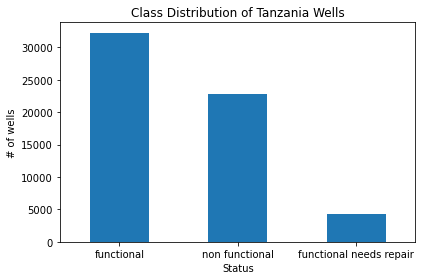

In [90]:
print(well_df['status_group'].value_counts())
well_df['status_group'].value_counts().plot(kind='bar', rot=0)
plt.title('Class Distribution of Tanzania Wells')
plt.xlabel('Status')
plt.ylabel('# of wells')
plt.tight_layout()
plt.savefig('images/class_distribution.png')

As we can see from the figure above, these classes are imbalanced. which may cause our models to become more biased towards the majority class, `functional`. While we could merge the `functional needs repair` entries into the `non functional` class, I believe that it is important to distinguish a functioning well in need of repair from an outright non-functional one. Depending on what resources are available to us, we might choose to perform maintenance on wells that need repair before performing work on non-functional wells, or vice versa. Therefore, I will proceed with creating our models with the data as is, keeping in mind that there is a possibility our data will be biased towards predicting functional wells instead.

## Data Preprocessing

Now that we have condensed our dataset to only include the columns most relevant to our analysis, I split them again into two separate data frames: one containing our target `status_group` and the other containing our predictors.

In [9]:
y = well_df['status_group']
X = well_df.drop(columns='status_group')

Since a majority of our predictors are categorical variables, we need to one hot encode the X dataframe using Pandas' `.get_dummies()` function so that our model can process these variables.

In [10]:
X = pd.get_dummies(X)
X.head()

,id,amount_tsh,gps_height,population,construction_year,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,...,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,69572,6000.0,1390,109,1999,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,8776,0.0,1399,280,2010,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,34310,25.0,686,250,2009,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,67743,0.0,263,58,1986,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,19728,0.0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


Before continuing, I review the information of the X dataframe with the new dummy columns created:

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 36 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   id                                        59400 non-null  int64  
 1   amount_tsh                                59400 non-null  float64
 2   gps_height                                59400 non-null  int64  
 3   population                                59400 non-null  int64  
 4   construction_year                         59400 non-null  int64  
 5   extraction_type_class_gravity             59400 non-null  uint8  
 6   extraction_type_class_handpump            59400 non-null  uint8  
 7   extraction_type_class_motorpump           59400 non-null  uint8  
 8   extraction_type_class_other               59400 non-null  uint8  
 9   extraction_type_class_rope pump           59400 non-null  uint8  
 10  extraction_type_class_submersible 

## Creating Our Models

Before we create our models, we split our data into training and test sets. By doing this, we avoid data leakage since this ensures that when we prepare our data to be fitted to our models, we retain a subset of our data, the test data, that is unaffected by any preprocessing or alterations and therefore can be used to evaluate the performance of our model later on.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

### Logistic Regression

Our first model will use the [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier. Normally this is designed for binary classification, but for our purposes we will include the `multinomial` argument so that we can perform classification on all our classes. To streamline the process of preparing the data to train our model, we create a pipeline from scikit-learn's `Pipeline` module.

In [27]:
logreg_pipeline = Pipeline([('ss', StandardScaler()), ('logreg', LogisticRegression(C=1.0, multi_class='multinomial'))])

Once we've established the pipeline, we fit the model on the training data:

In [28]:
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('logreg', LogisticRegression(multi_class='multinomial'))])

We can measure the performance of our model before evaluating it with the test data by using cross-validation, which splits the training set into smaller subsets, or "folds", and tests the model among the rest of the data. We perform this evaluation using scikit-learn's [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function.

In [71]:
cross_val_score(logreg_pipeline, X, y, cv=5, scoring='f1_micro')

array([0.70075758, 0.69570707, 0.70597643, 0.70740741, 0.70732323])

Just from cross-validation, it seems that our logistic regression model performs well to predict a well's condition! However, we still want to measure the performance of our model against our test data that we held out from our training data earlier. I chose to use [f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) as our primary metric, which returns the weighted mean of the precision and recall of our model. In the context of our problem, our F1 score will give us a general idea of how effectively our model can identify the status of a well without falsely classifying it under the wrong status (i.e. identifying a non functional well as functional).

In [30]:
logreg_y_pred = logreg_pipeline.predict(X_test)
f1_score(y_test, logreg_y_pred, average='micro')

0.7004040404040404

Overall, our F1 score gives us about the same result as our cross-validated score, the only significant difference being that the F1 score is averaged across our three classes. To gain a better idea of how well our model can distinguish between classes, we can also use a confusion matrix to see how often our model identified wells under their true labels against the labels our model predicted.

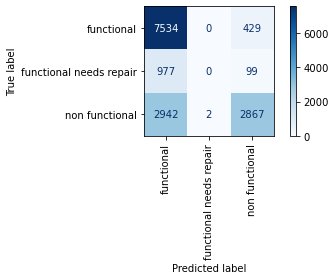

In [81]:
plot_confusion_matrix(logreg_pipeline, X_test, y_test, xticks_rotation='vertical', cmap='Blues')
plt.savefig('images/logreg_confusion_matrix')

### Random Forest

Our next model will utilize the [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier.

In [38]:
rf_pipeline = Pipeline([('ss', StandardScaler()), ('rf', RandomForestClassifier())])

Fitting the model:

In [39]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('rf', RandomForestClassifier())])

Cross-validating the model:

In [40]:
cross_val_score(rf_pipeline, X, y, cv=5)

array([0.72727273, 0.72222222, 0.72853535, 0.725     , 0.72718855])

Obtaining the F1 score for this model:

In [41]:
rf_y_pred = rf_pipeline.predict(X_test)
f1_score(y_test, rf_y_pred, average='micro')

0.7196632996632997

It seems that our Random Forest classifier slightly outperforms our Logistic Regression model, as we see higher cross-validated scores and a higher F1 score. 

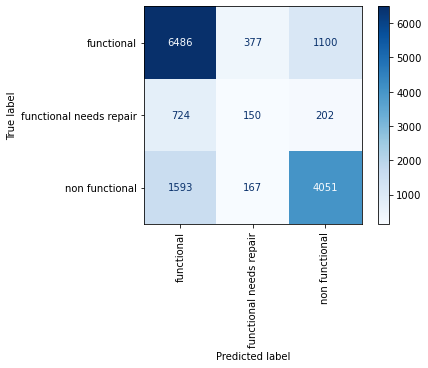

In [74]:
plot_confusion_matrix(rf_pipeline, X_test, y_test, xticks_rotation='vertical', cmap='Blues')
plt.savefig('images/rf_confusion_matrix')

This classifier's better performance also reflects in its confusion matrix; it was able to identify more non-functional and functional needs repair wells than our first model!

### Gaussian Naive Bayes

For our third model, I use a [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) model, which is derived from Bayes' Theorem

In [18]:
gnb_pipeline = Pipeline([('ss', StandardScaler()), ('gnb', GaussianNB())])

Fitting the model:

In [19]:
gnb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('gnb', GaussianNB())])

Cross-validating the model:

In [20]:
cross_val_score(gnb_pipeline, X, y, cv=5)

array([0.22415825, 0.29200337, 0.20505051, 0.24654882, 0.2280303 ])

Obtaining the F1 score:

In [21]:
gnb_y_pred = gnb_pipeline.predict(X_test)
f1_score(y_test, gnb_y_pred, average='micro')

0.2235016835016835

Unfortunately, this classifier seems to perform significantly worse than our first two models.

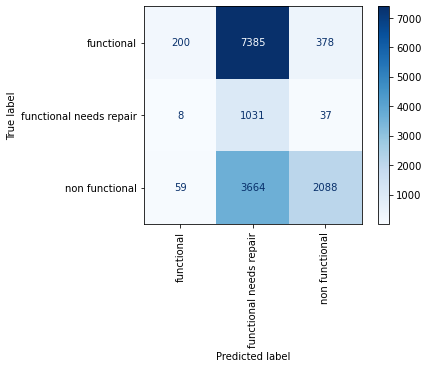

In [73]:
plot_confusion_matrix(gnb_pipeline, X_test, y_test, xticks_rotation='vertical', cmap='Blues')
plt.savefig('images/gnb_confusion_matrix')

The confusion matrix also shows a less than ideal performance of the Naive Bayes model, showing us that it identified most of our water wells as "functional needs repair" with no regard to whether it was actually functional or non-functional.

### Tuning our best model

It seems that our Random Forest model performed the best in predicting whether a well was either "non functional" or "functional needs repair", with the highest F1 score of our three models. Since we ran the model using the default values for each parameter in the scikit-learn algorithm, we can attempt to go further and use hyperparameter tuning methods to find the optimal parameters with which we can train our model.

To get an idea of what these "default" parameters were, we can call the `get_params` attribute of our original model:

In [72]:
rf_pipeline.get_params()

{'memory': None,
 'steps': [('ss', StandardScaler()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'ss': StandardScaler(),
 'rf': RandomForestClassifier(),
 'ss__copy': True,
 'ss__with_mean': True,
 'ss__with_std': True,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': None,
 'rf__verbose': 0,
 'rf__warm_start': False}

From there, we can create a parameter grid with different parameter values to test on our model:

In [64]:
param_grid = {
    "rf__criterion": ["gini", "entropy"],
    "rf__max_depth": [None, 2, 6, 10],
    "rf__min_samples_split": [5, 10],
    "rf__min_samples_leaf": [3, 6]
}

We then use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and utilize the test parameter grid we created to find the parameters that will give us the best performance out of our model. This process takes place once we fit our model.

In [68]:
rf_grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, scoring='f1_micro')

In [69]:
rf_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [None, 2, 6, 10],
                         'rf__min_samples_leaf': [3, 6],
                         'rf__min_samples_split': [5, 10]},
             scoring='f1_micro')

After fitting the grid search model, we can then call on its `best_score_` and `best_params_` attributes to evaluate the performance of our new model and see which parameters contributed to its performance.

In [70]:
print(rf_grid_search.best_score_)
print(rf_grid_search.best_params_)

0.7538047138047139
{'rf__criterion': 'entropy', 'rf__max_depth': None, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 5}


Using the grid search, we were able to identify parameter values that ended up improving our Random Forest classifier's performance!

## Conclusion

We were able to identify that of the three models that we trained using our data, the Random Forest classifier was able to classify the condition of Tanzania water wells while minimizing the amount of false positives and negatives from misidentifying wells' conditions the best of our models. We were also able to find optimal parameters through hyperparameter tuning with `GridSearchCV` to further improve the performance of our random forest classifier. 

While it isn't perfect, a classifier that correctly identifies 75% of water wells in Tanzania is significant enough to help us start planning the allocation of our resources towards well maintenance while we also can plan on drilling more wells. Furthermore, this model will also be receptive to future well data so that we can continue to monitor Tanzania well conditions as we develop more.

### Next Steps

- For the sake of simplicity and performance, these models do not include specific subtypes of the attributes included (e.g. extraction types). We could create a model in the future for each attribute that takes these subtypes into account, possibly to gain a better understanding of which wells need repair.
- Doing more research on geological and ecological factors that might impact the performance and condition of water wells may also help us plan the process of performing work on Tanzania's water wells. Water quality is also important to providing sanitary water to villages, and involves many other factors beyond the scope of what is covered in this dataset.
- If we want to broaden our model to accomodate for wells across Africa, we can run our best model again provided data on water wells from other regions in Africa.